# Assignment -1 AI for MI

## Installation and Import

In [ ]:
!pip install nibabel numpy matplotlib

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging
import os
import random
from tqdm.notebook import tqdm
import torch

In [ ]:
question_folder = "/content/drive/MyDrive/datasets/AIMI_ASS1_Files"
ground_truth = "/content/drive/MyDrive/datasets/GroundTruth"

## helper functions

In [ ]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [ ]:
def get_sequences(file_name):
    file_name = file_name.lower()
    if 't1' in file_name:
        return 't1'
    elif 't2' in file_name:
        return 't2'
    elif 'flair' in file_name:
        return 'flair'
    else:
        return "Exception"

def calculate_distance(point, center):
    return (point - center) ** 2

In [ ]:
def file_processer(directory, k, save_dir, max_iterations=1000):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            #print(file)
            if file.endswith('.nii.gz'):
                file_list.append((file, root, k, save_dir, max_iterations))

    logger.info(f"Starting sequential k-means processing")
    #print(file_list)

    results = []
    for file_info in tqdm(file_list):
        result = k_means(file_info)
        if result is not None:
            results.append(result)

    logger.info("k-means clustering completed for all files")
    return results

## Kmeans from Scratch

In [ ]:
def k_means(file_info):
    file, directory, k, save_dir, max_iterations = file_info
    #print(file)

    # Run on few samples to get empirical centers for faster convergence
    empirical_centers = {
        't1': { 2 : [790, 457],
                3: [291, 832.0, 590.5],},
        't2': { 2 : [363, 181],
                3: [168.5, 409, 227.0],},
        'flair': { 2 : [140, 83],
                   3: [71, 152, 127.4],},
        'Exeption' : {2: [random.randint(11, 300) for i in range(2)],
                      3: [random.randint(11, 300) for i in range(3)],
                      },
    }

    sequences = get_sequences(file)

    if sequences == "Exception":
        logger.warning(f"Resetting center to random values for {file}: Unable to determine sequences")

    if sequences not in empirical_centers or k not in empirical_centers[sequences]:
        raise ValueError(f"Unsupported model or k for file {file}: sequences={sequences}, k={k}")

    centres = np.array(empirical_centers[sequences][k], dtype=np.float32)

    file_path = os.path.join(directory, file)
    img = nib.load(file_path)
    data = img.get_fdata()

    flattened_data = data.flatten()

    # Allocate labels
    labels = np.zeros_like(flattened_data, dtype=np.int8)

    for iteration in range(max_iterations):
        old_labels = np.copy(labels)

        # Assign each point to the nearest center
        for i, point in enumerate(flattened_data):
            if point != 0:  # Ignore background voxels
                distances = [calculate_distance(point, center) for center in centres]
                labels[i] = np.argmin(distances) + 1
        #print("distance calculated")

        # Update centers
        for j in range(k):
            mask = labels == (j + 1)
            if np.sum(mask) > 0:
                centres[j] = np.mean(flattened_data[mask])

        #print("center updated")
        if np.array_equal(old_labels, labels):
            break
        #print("loop over")

        segmented_data = labels.reshape(data.shape)

        # Save segmented data
        segmented_img = nib.Nifti1Image(segmented_data, img.affine, img.header)
        subject_name = os.path.basename(os.path.dirname(file_path))
        # naming covention 	ii) Naming Convention for output segmentation masks - Sub_{subNo}_{SeqName}_{K_value}.nii.gz
        k_folder = os.path.join(save_dir, f"k={k}", subject_name)
        output_folder = os.path.join(k_folder, "segmented")
        os.makedirs(output_folder, exist_ok=True)
        output_folder2 = os.path.join(save_dir, "segmented")
        os.makedirs(output_folder2, exist_ok=True)
        output_file2 = os.path.join(output_folder2, f"{subject_name[:3]}_{subject_name[3:]}_{sequences.upper()}_{k}.nii.gz")

        output_file = os.path.join(output_folder, f"segmented_{k}_{file}")
        nib.save(segmented_img, output_file)
        nib.save(segmented_img, output_file2)

        print(f"Segmentation completed for {file} with k={k}, model={sequences}, centers={centres.tolist()} at iteration {iteration}")

        return centres.tolist()

## segmentation, metric calculation and Observation

In [ ]:
if __name__ == "__main__":

    k_values = [2, 3]
    for k in k_values:
        directory = "/content/drive/MyDrive/datasets/AIMI_ASS1_Files"
        save_dir = "/content/drive/MyDrive/model prediction AIMI/final_run"
        final_centres = file_processer(directory, k, save_dir)
        print(f"Final centres for k={k}: {final_centres}")

  0%|          | 0/60 [00:00<?, ?it/s]

Segmentation completed for T1_pre_restore.nii.gz with k=2, model=t1, centers=[803.5606079101562, 434.605712890625] at iteration 0
Segmentation completed for T2_pre_restore.nii.gz with k=2, model=t2, centers=[376.474609375, 179.7407684326172] at iteration 0
Segmentation completed for FLAIR_pre_restore.nii.gz with k=2, model=flair, centers=[140.5082550048828, 78.18310546875] at iteration 0
Segmentation completed for T1_pre_restore.nii.gz with k=2, model=t1, centers=[809.3873901367188, 456.08306884765625] at iteration 0
Segmentation completed for T2_pre_restore.nii.gz with k=2, model=t2, centers=[355.15936279296875, 205.2095947265625] at iteration 0
Segmentation completed for FLAIR_pre_restore.nii.gz with k=2, model=flair, centers=[149.3914031982422, 81.41079711914062] at iteration 0
Segmentation completed for T1_pre_restore.nii.gz with k=2, model=t1, centers=[780.0728149414062, 467.32574462890625] at iteration 0
Segmentation completed for T2_pre_restore.nii.gz with k=2, model=t2, centers

  0%|          | 0/60 [00:00<?, ?it/s]

Segmentation completed for T1_pre_restore.nii.gz with k=3, model=t1, centers=[274.1185607910156, 843.3353271484375, 594.3216552734375] at iteration 0
Segmentation completed for T2_pre_restore.nii.gz with k=3, model=t2, centers=[164.6622772216797, 420.1759338378906, 230.1355438232422] at iteration 0
Segmentation completed for FLAIR_pre_restore.nii.gz with k=3, model=flair, centers=[67.38141632080078, 154.1797637939453, 126.47822570800781] at iteration 0
Segmentation completed for T1_pre_restore.nii.gz with k=3, model=t1, centers=[287.0351257324219, 853.3856811523438, 592.9067993164062] at iteration 0
Segmentation completed for T2_pre_restore.nii.gz with k=3, model=t2, centers=[175.7545166015625, 406.6795349121094, 232.14178466796875] at iteration 0
Segmentation completed for FLAIR_pre_restore.nii.gz with k=3, model=flair, centers=[69.94258117675781, 158.64743041992188, 127.53414916992188] at iteration 0
Segmentation completed for T1_pre_restore.nii.gz with k=3, model=t1, centers=[299.72

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def tpr(gt_class, seg_class, data, ground_truth):
    gt_array = torch.tensor(ground_truth, device=device)
    seg_array = torch.tensor(data, device=device)

    gt_mask = (gt_array == gt_class)
    tp = torch.sum((seg_array == seg_class) & gt_mask).item()
    fn = torch.sum((seg_array != seg_class) & gt_mask).item()

    if tp + fn == 0:
        tpr = 0.0
    else:
        tpr = tp / (tp + fn)

    return {
        "TP_tpr": tp,
        "FN_tpr": fn,
        "TPR": tpr,
    }

def dice_score(gt_class, seg_class, data, ground_truth):
    gt_array = torch.tensor(ground_truth, device=device)
    seg_array = torch.tensor(data, device=device)

    gt_mask = (gt_array == gt_class)
    seg_mask = (seg_array == seg_class)

    tp = torch.sum(gt_mask & seg_mask).item()
    fp = torch.sum((~gt_mask) & seg_mask).item()
    fn = torch.sum(gt_mask & (~seg_mask)).item()

    denominator = tp + fp + fn
    if denominator == 0:
        dice = 0.0
    else:
        dice = 2 * tp / denominator

    return {
        "TP_dice": tp,
        "FN_dice": fn,
        "FP_dice": fp,
        "Dice": dice,
    }

def process_subject(subject_folder, gt_parent_folder, seg_parent_folder, k):
    results = []

    gt_path = os.path.join(gt_parent_folder, subject_folder, 'Gt.nii.gz')
    seg_subject_folder = f"Sub{subject_folder[3:]}"
    seg_folder = os.path.join(seg_parent_folder, seg_subject_folder, 'segmented')

    gt_img = nib.load(gt_path)
    gt_data = gt_img.get_fdata()
    try:
        for modality in ['T1', 'T2', 'FLAIR']:
            seg_files = [f for f in os.listdir(seg_folder) if f.startswith(f'segmented_{k}_{modality}')]

            if not seg_files:
                continue

            seg_path = os.path.join(seg_folder, seg_files[0])
            seg_img = nib.load(seg_path)
            seg_data = seg_img.get_fdata()

            for gt_class in range(1, 4):
                for seg_class in range(1, k+1):
                    tpr_value = tpr(gt_class, seg_class, seg_data, gt_data)
                    dice_value = dice_score(gt_class, seg_class, seg_data, gt_data)

                    data = {
                        'Subject': subject_folder,
                        'sequences': modality,
                        'k': k,
                        'GT_Class': gt_class,
                        'Seg_Class': seg_class,
                    }

                    data.update(tpr_value)
                    data.update(dice_value)

                    results.append(data)

        return results
    except:
      return [{'Subject': subject_folder,}]

def process_segmentation_results(gt_parent_folder, seg_parent_folder, k):
    subject_folders = [f for f in os.listdir(gt_parent_folder) if f.startswith('Sub')]

    all_results = []
    for subject in tqdm(subject_folders, desc="Processing Subjects"):
        all_results.extend(process_subject(subject, gt_parent_folder, seg_parent_folder, k))

    df = pd.DataFrame(all_results)
    return df

In [ ]:
if __name__ == '__main__':
    gt_parent_folder = "/content/drive/MyDrive/datasets/GroundTruth/"
    seg_parent_folder = "/content/drive/MyDrive/model prediction AIMI/final_run/k=2"
    k = 2

    results_df_k2 = process_segmentation_results(gt_parent_folder, seg_parent_folder, k)

    #print("Detailed Results:")
    #print(results_df_k2)
    seg_parent_folder = "/content/drive/MyDrive/model prediction AIMI/final_run/k=3"
    k = 3

    results_df_k3 = process_segmentation_results(gt_parent_folder, seg_parent_folder, k)

    #print("Detailed Results:")
    #print(results_df_k2)


Processing Subjects:   0%|          | 0/20 [00:00<?, ?it/s]

Processing Subjects:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
results_df = pd.concat([results_df_k3, results_df_k2], axis=0)

print(results_df)

    Subject sequences  k  GT_Class  Seg_Class  TP_tpr  FN_tpr       TPR  \
0      Sub8        T1  3         1          1  182261   16761  0.915783   
1      Sub8        T1  3         1          2     667  198355  0.003351   
2      Sub8        T1  3         1          3   16094  182928  0.080865   
3      Sub8        T1  3         2          1    3153  556320  0.005636   
4      Sub8        T1  3         2          2   28445  531028  0.050842   
..      ...       ... ..       ...        ...     ...     ...       ...   
355   Sub14     FLAIR  2         1          2  126186  129273  0.493958   
356   Sub14     FLAIR  2         2          1  554283   43340  0.927479   
357   Sub14     FLAIR  2         2          2   43340  554283  0.072521   
358   Sub14     FLAIR  2         3          1  663998   19436  0.971561   
359   Sub14     FLAIR  2         3          2   19436  663998  0.028439   

     TP_dice  FN_dice  FP_dice      Dice  
0     182261    16761     3153  1.803002  
1        667 

In [ ]:
results_df.to_csv("/content/drive/MyDrive/model prediction AIMI/final_run/results_df.csv")

In [8]:
df_sorted = results_df.sort_values(["k", 'Subject', 'sequences', 'Seg_Class', 'GT_Class'])

In [9]:
df1 = df_sorted.copy()
df2 = df_sorted.copy()


# For TPR maximum
df_tpr_max = df1.loc[df1.groupby(['Subject', 'sequences', 'k', 'Seg_Class'])['TPR'].idxmax()]

# For Dice maximum
df_dice_max = df2.loc[df2.groupby(['Subject', 'sequences', 'k', 'Seg_Class'])['Dice'].idxmax()]

In [10]:
df_dice_max

,Unnamed: 0,Subject,sequences,k,GT_Class,Seg_Class,TP_tpr,FN_tpr,TPR,TP_dice,FN_dice,FP_dice,Dice
770,230,Sub1,FLAIR,2,2,1,483518,37649,0.927760,483518,37649,554302,0.899176
769,229,Sub1,FLAIR,2,1,2,114286,99155,0.535445,114286,99155,65643,0.819008
342,342,Sub1,FLAIR,3,1,1,92955,120486,0.435507,92955,120486,30316,0.762686
346,346,Sub1,FLAIR,3,2,2,289171,231996,0.554853,289171,231996,218423,0.781977
350,350,Sub1,FLAIR,3,3,3,294974,188149,0.610557,294974,188149,291910,0.761191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,134,Sub9,T2,2,2,1,221221,227418,0.493094,221221,227418,102660,0.802545
677,137,Sub9,T2,2,3,2,415961,42284,0.907726,415961,42284,279150,1.128190
198,198,Sub9,T2,3,1,1,30515,80816,0.274093,30515,80816,66822,0.342571
199,199,Sub9,T2,3,1,2,36845,74486,0.330950,36845,74486,43849,0.474868


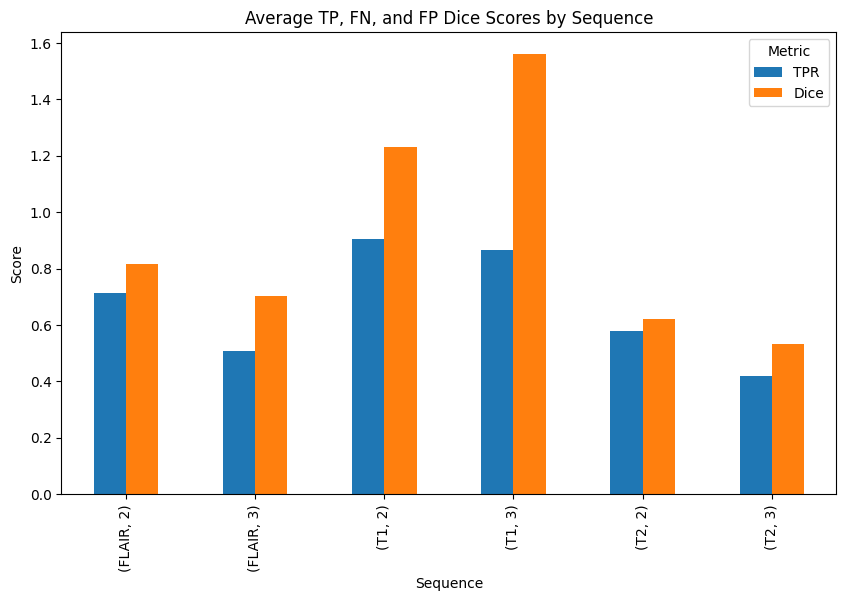

In [11]:
df_grouped = df_dice_max.groupby(['sequences', "k"])[['TPR', 'Dice']].mean()
df_grouped.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Average TP, FN, and FP Dice Scores by Sequence')
plt.xlabel('Sequence')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.show()

In [12]:
df_grouped

TPR      Dice
sequences k                    
FLAIR     2  0.711833  0.817641
          3  0.507581  0.703625
T1        2  0.905735  1.232375
          3  0.867386  1.560472
T2        2  0.579114  0.619601
          3  0.419748  0.530755

In [13]:
df_grouped.to_csv("/content/drive/MyDrive/model prediction AIMI/final_run/average.csv")

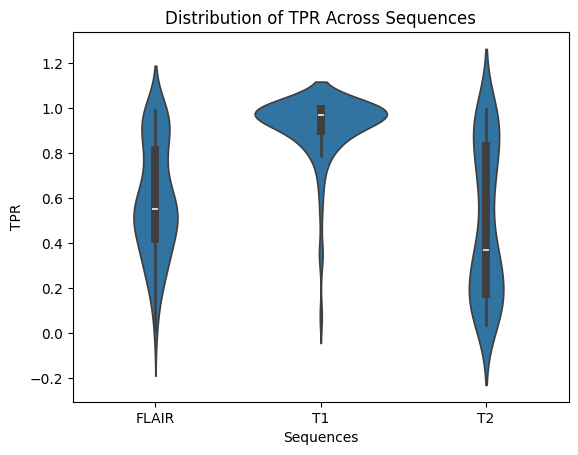

In [24]:
sns.violinplot(data=df_tpr_max, x='sequences', y='TPR')

plt.title('Distribution of TPR Across Sequences')
plt.xlabel('Sequences')
plt.ylabel('TPR')

plt.show()

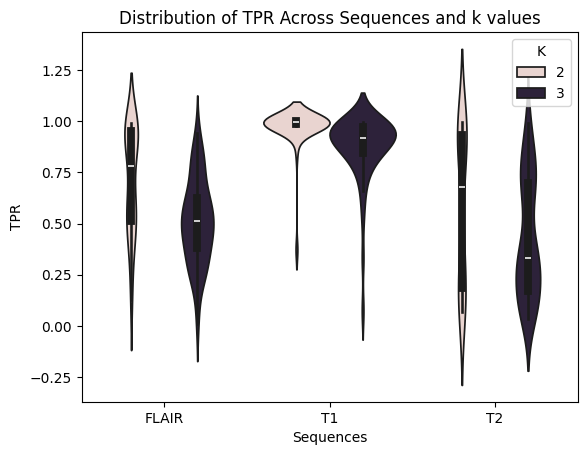

In [32]:
sns.violinplot(data=df_tpr_max, x='sequences', y='TPR', hue='k')

plt.title('Distribution of TPR Across Sequences and k values')
plt.xlabel('Sequences')
plt.ylabel('TPR')
plt.legend(title='K')

plt.show()

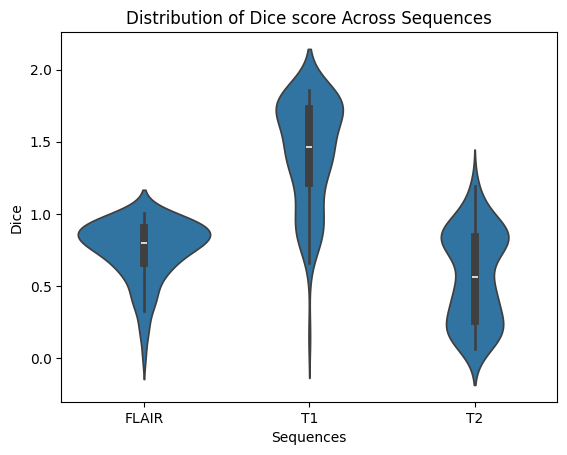

In [26]:
# Violin plot comparing TPR distributions across different sequences
sns.violinplot(data=df_dice_max, x='sequences', y='Dice')

# Add titles and labels
plt.title('Distribution of Dice score Across Sequences')
plt.xlabel('Sequences')
plt.ylabel('Dice')

# Show the plot
plt.show()


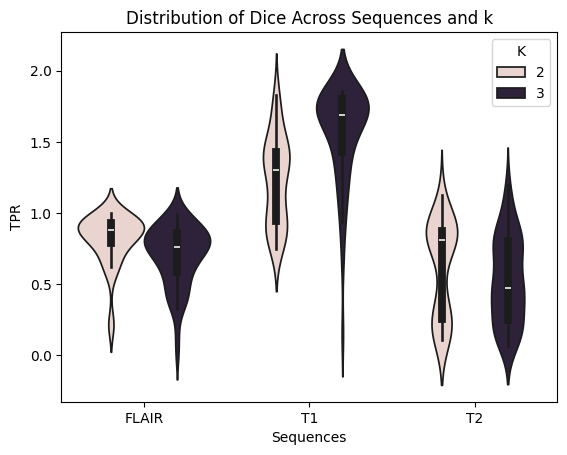

In [33]:
sns.violinplot(data=df_dice_max, x='sequences',hue = "k", y='Dice')

plt.title('Distribution of Dice Across Sequences and k')
plt.xlabel('Sequences')
plt.ylabel('TPR')
plt.legend(title='K')

plt.show()

# 2 sample output for each sequence

In [ ]:
!ls /content/drive/MyDrive/datasets/AIMI_ASS1_Files/Sub1

FLAIR_pre_restore.nii.gz  T1_pre_restore.nii.gz  T2_pre_restore.nii.gz


In [ ]:
file1 = "/content/drive/MyDrive/dataset/AIMI_ASS1_Files/Sub1/FLAIR_pre_restore.nii.gz"
file2 = "/content/drive/MyDrive/dataset/AIMI_ASS1_Files/Sub1/T1_pre_restore.nii.gz"
file3 = "/content/drive/MyDrive/dataset/AIMI_ASS1_Files/Sub1/T2_pre_restore.nii.gz"
file4 = "/content/drive/MyDrive/dataset/AIMI_ASS1_Files/Sub2/FLAIR_pre_restore.nii.gz"
file5 = "/content/drive/MyDrive/dataset/AIMI_ASS1_Files/Sub2/T1_pre_restore.nii.gz"
file6 = "/content/drive/MyDrive/dataset/AIMI_ASS1_Files/Sub2/T2_pre_restore.nii.gz"

In [ ]:
directory1 = "/content/drive/MyDrive/datasets/AIMI_ASS1_Files/Sub1"
directory2  = "/content/drive/MyDrive/datasets/AIMI_ASS1_Files/Sub1"

In [ ]:
if __name__ == "__main__":

    k_values = [2, 3]
    for k in k_values:
        directory = directory1
        save_dir = "/content/drive/MyDrive/model prediction AIMI/sample_output"
        final_centres = file_processer(directory, k, save_dir)
        print(f"Final centres for k={k}: {final_centres}")

  0%|          | 0/3 [00:00<?, ?it/s]

Segmentation completed for T1_pre_restore.nii.gz with k=2, model=t1, centers=[752.844482421875, 437.12176513671875] at iteration 0
Segmentation completed for T2_pre_restore.nii.gz with k=2, model=t2, centers=[364.2904052734375, 183.45407104492188] at iteration 0
Segmentation completed for FLAIR_pre_restore.nii.gz with k=2, model=flair, centers=[140.65870666503906, 80.22351837158203] at iteration 0
Final centres for k=2: [[752.844482421875, 437.12176513671875], [364.2904052734375, 183.45407104492188], [140.65870666503906, 80.22351837158203]]


  0%|          | 0/3 [00:00<?, ?it/s]

Segmentation completed for T1_pre_restore.nii.gz with k=3, model=t1, centers=[274.4925231933594, 802.7435302734375, 585.6654663085938] at iteration 0
Segmentation completed for T2_pre_restore.nii.gz with k=3, model=t2, centers=[167.1641845703125, 405.1554260253906, 229.44851684570312] at iteration 0
Segmentation completed for FLAIR_pre_restore.nii.gz with k=3, model=flair, centers=[68.33132934570312, 153.32485961914062, 126.36724090576172] at iteration 0
Final centres for k=3: [[274.4925231933594, 802.7435302734375, 585.6654663085938], [167.1641845703125, 405.1554260253906, 229.44851684570312], [68.33132934570312, 153.32485961914062, 126.36724090576172]]


In [ ]:
if __name__ == "__main__":

    k_values = [2, 3]
    for k in k_values:
        directory = directory2
        save_dir = "/content/drive/MyDrive/model prediction AIMI/sample_output"
        final_centres = file_processer(directory, k, save_dir)
        print(f"Final centres for k={k}: {final_centres}")

  0%|          | 0/3 [00:00<?, ?it/s]

Segmentation completed for T1_pre_restore.nii.gz with k=2, model=t1, centers=[752.844482421875, 437.12176513671875] at iteration 0
Segmentation completed for T2_pre_restore.nii.gz with k=2, model=t2, centers=[364.2904052734375, 183.45407104492188] at iteration 0
Segmentation completed for FLAIR_pre_restore.nii.gz with k=2, model=flair, centers=[140.65870666503906, 80.22351837158203] at iteration 0
Final centres for k=2: [[752.844482421875, 437.12176513671875], [364.2904052734375, 183.45407104492188], [140.65870666503906, 80.22351837158203]]


  0%|          | 0/3 [00:00<?, ?it/s]

Segmentation completed for T1_pre_restore.nii.gz with k=3, model=t1, centers=[274.4925231933594, 802.7435302734375, 585.6654663085938] at iteration 0
Segmentation completed for T2_pre_restore.nii.gz with k=3, model=t2, centers=[167.1641845703125, 405.1554260253906, 229.44851684570312] at iteration 0
Segmentation completed for FLAIR_pre_restore.nii.gz with k=3, model=flair, centers=[68.33132934570312, 153.32485961914062, 126.36724090576172] at iteration 0
Final centres for k=3: [[274.4925231933594, 802.7435302734375, 585.6654663085938], [167.1641845703125, 405.1554260253906, 229.44851684570312], [68.33132934570312, 153.32485961914062, 126.36724090576172]]


In [ ]:
if __name__ == '__main__':
    gt_parent_folder = "/content/drive/MyDrive/datasets/GroundTruth/"
    seg_parent_folder = "/content/drive/MyDrive/model prediction AIMI/sample_output/k=2"
    k = 2

    results_df_k2 = process_segmentation_results(gt_parent_folder, seg_parent_folder, k)

    #print("Detailed Results:")
    #print(results_df_k2)
    seg_parent_folder = "/content/drive/MyDrive/model prediction AIMI/sample_output/k=3"
    k = 3

    results_df_k3 = process_segmentation_results(gt_parent_folder, seg_parent_folder, k)

    #print("Detailed Results:")
    #print(results_df_k2)


Processing Subjects:   0%|          | 0/20 [00:00<?, ?it/s]

Processing Subjects:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
results_df = pd.concat([results_df_k3, results_df_k2], axis=0)

print(results_df)

   Subject sequences   k  GT_Class  Seg_Class  TP_tpr  FN_tpr  TPR  TP_dice  \
0     Sub8       NaN NaN       NaN        NaN     NaN     NaN  NaN      NaN   
1     Sub5       NaN NaN       NaN        NaN     NaN     NaN  NaN      NaN   
2     Sub7       NaN NaN       NaN        NaN     NaN     NaN  NaN      NaN   
3    Sub20       NaN NaN       NaN        NaN     NaN     NaN  NaN      NaN   
4    Sub19       NaN NaN       NaN        NaN     NaN     NaN  NaN      NaN   
..     ...       ...  ..       ...        ...     ...     ...  ...      ...   
32   Sub18       NaN NaN       NaN        NaN     NaN     NaN  NaN      NaN   
33   Sub13       NaN NaN       NaN        NaN     NaN     NaN  NaN      NaN   
34   Sub12       NaN NaN       NaN        NaN     NaN     NaN  NaN      NaN   
35   Sub11       NaN NaN       NaN        NaN     NaN     NaN  NaN      NaN   
36   Sub14       NaN NaN       NaN        NaN     NaN     NaN  NaN      NaN   

    FN_dice  FP_dice  Dice  
0       NaN      NaN  

In [ ]:
clean_df = results_df.dropna()
clean_df

,Subject,sequences,k,GT_Class,Seg_Class,TP_tpr,FN_tpr,TPR,TP_dice,FN_dice,FP_dice,Dice
12,Sub1,T1,3.0,1.0,1.0,209146.0,4295.0,0.979877,209146.0,4295.0,41079.0,1.643454
13,Sub1,T1,3.0,1.0,2.0,207.0,213234.0,0.000970,207.0,213234.0,360468.0,0.000721
14,Sub1,T1,3.0,1.0,3.0,4088.0,209353.0,0.019153,4088.0,209353.0,602743.0,0.010017
15,Sub1,T1,3.0,2.0,1.0,41079.0,480088.0,0.078821,41079.0,480088.0,209146.0,0.112497
16,Sub1,T1,3.0,2.0,2.0,3565.0,517602.0,0.006840,3565.0,517602.0,357110.0,0.008118
17,Sub1,T1,3.0,2.0,3.0,476523.0,44644.0,0.914338,476523.0,44644.0,130308.0,1.462905
18,Sub1,T1,3.0,3.0,1.0,0.0,483123.0,0.000000,0.0,483123.0,250225.0,0.000000
19,Sub1,T1,3.0,3.0,2.0,356903.0,126220.0,0.738741,356903.0,126220.0,3772.0,1.466037
20,Sub1,T1,3.0,3.0,3.0,126220.0,356903.0,0.261259,126220.0,356903.0,480611.0,0.261939
21,Sub1,T2,3.0,1.0,1.0,124535.0,88906.0,0.583463,124535.0,88906.0,642593.0,0.290958


In [ ]:
df_sorted = clean_df.sort_values(["k", 'Subject', 'sequences', 'Seg_Class', 'GT_Class'])
df_sorted

,Subject,sequences,k,GT_Class,Seg_Class,TP_tpr,FN_tpr,TPR,TP_dice,FN_dice,FP_dice,Dice
24,Sub1,FLAIR,2.0,1.0,1.0,99155.0,114286.0,0.464555,99155.0,114286.0,938665.0,0.172128
26,Sub1,FLAIR,2.0,2.0,1.0,483518.0,37649.0,0.927760,483518.0,37649.0,554302.0,0.899176
28,Sub1,FLAIR,2.0,3.0,1.0,455140.0,27983.0,0.942079,455140.0,27983.0,582680.0,0.854079
25,Sub1,FLAIR,2.0,1.0,2.0,114286.0,99155.0,0.535445,114286.0,99155.0,65643.0,0.819008
27,Sub1,FLAIR,2.0,2.0,2.0,37649.0,483518.0,0.072240,37649.0,483518.0,142280.0,0.113495
29,Sub1,FLAIR,2.0,3.0,2.0,27983.0,455140.0,0.057921,27983.0,455140.0,151946.0,0.088126
12,Sub1,T1,2.0,1.0,1.0,323.0,213118.0,0.001513,323.0,213118.0,573971.0,0.000820
14,Sub1,T1,2.0,2.0,1.0,93949.0,427218.0,0.180267,93949.0,427218.0,480345.0,0.187614
16,Sub1,T1,2.0,3.0,1.0,480022.0,3101.0,0.993581,480022.0,3101.0,94272.0,1.662716
13,Sub1,T1,2.0,1.0,2.0,213118.0,323.0,0.998487,213118.0,323.0,430319.0,0.662104


In [ ]:
df1 = df_sorted.copy()
df2 = df_sorted.copy()


# For TPR maximum
df_tpr_max = df1.loc[df1.groupby(['Subject', 'sequences', 'k', 'Seg_Class'])['TPR'].idxmax()]

# For Dice maximum
df_dice_max = df2.loc[df2.groupby(['Subject', 'sequences', 'k', 'Seg_Class'])['Dice'].idxmax()]

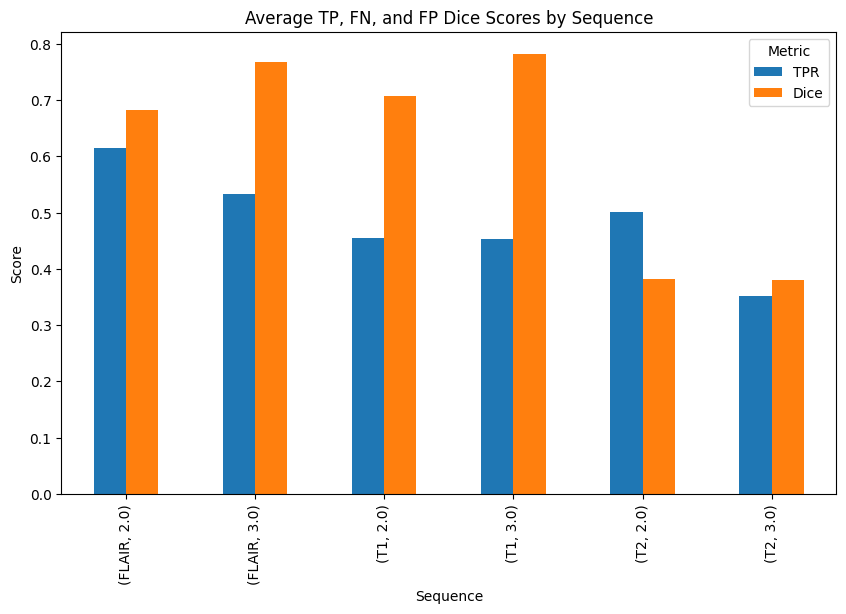

In [ ]:
df_grouped = df_dice_max.groupby(['sequences', "k"])[['TPR', 'Dice']].mean()
df_grouped.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Average TP, FN, and FP Dice Scores by Sequence')
plt.xlabel('Sequence')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.show()

In [ ]:
df_grouped

TPR      Dice
sequences k                      
FLAIR     2.0  0.615801  0.682714
          3.0  0.533639  0.768618
T1        2.0  0.455312  0.706948
          3.0  0.453103  0.782169
T2        2.0  0.502048  0.382532
          3.0  0.352795  0.380348

In [ ]:
df_grouped.to_csv("/content/drive/MyDrive/model prediction AIMI/sample_output/average.csv")

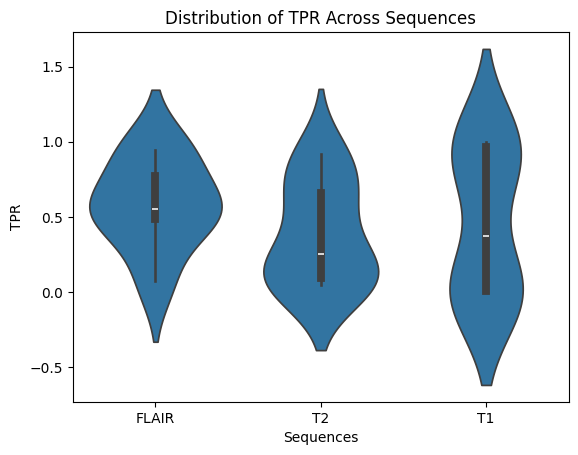

In [ ]:
# Violin plot comparing TPR distributions across different sequences
sns.violinplot(data=df_tpr_max, x='sequences', y='TPR')

# Add titles and labels
plt.title('Distribution of TPR Across Sequences')
plt.xlabel('Sequences')
plt.ylabel('TPR')

# Show the plot
plt.show()


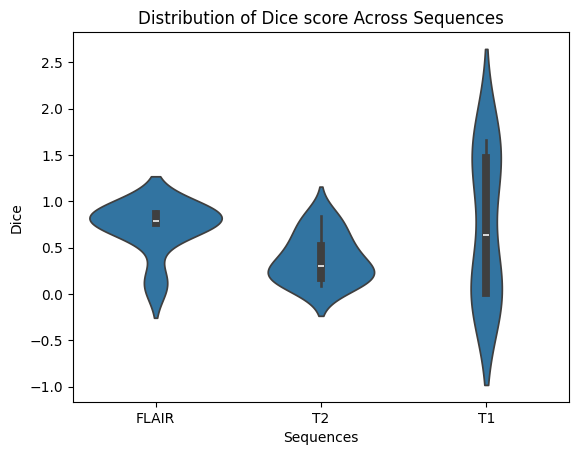

In [ ]:
# Violin plot comparing TPR distributions across different sequences
sns.violinplot(data=df_dice_max, x='sequences', y='Dice')

# Add titles and labels
plt.title('Distribution of Dice score Across Sequences')
plt.xlabel('Sequences')
plt.ylabel('Dice')

# Show the plot
plt.show()
